<a href="https://colab.research.google.com/github/nakampany/DeepLearning2022/blob/main/10_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GANの実装
## 概要
- GANの原著論文のPytorch実装を通して，GANの理解を深めることを目的とする．
 - I. Goodfellow, et al., "Generative Adversarial Nets", In Proc. of the NIPS 2014.
 - https://papers.nips.cc/paper/2014/hash/5ca3e9b122f61f8f06494c97b1afccf3-Abstract.html
- 初代GANはGもDも<b>Multi Layer Perceptron (MLP)</b>で実装されている．
- データセットは0-9の手書き数字認識データセットのMNISTを用いる．

## MNIST
- 0-9の手書き数字認識データセット
- 訓練用6万枚，検証用1万枚の画像＋ラベル（0-9）のペアで構成される．
- 一枚の画像はグレースケール(1ch)の28x28のため，$\boldsymbol{x} \in R^{60000 \times 1 \times 28 \times 28}$
- http://yann.lecun.com/exdb/mnist/

In [ ]:
# MNISTデータセットをロードする。
import torch
import torchvision
from torchvision import datasets, transforms
'''
datasets.MNIST.resources = [
    ('https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz', 'f68b3c2dcbeaaa9fbdd348bbdeb94873'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz', 'd53e105ee54ea40749a09fcbcd1e9432'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz', '9fb629c4189551a2d022fa330f9573f3'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz', 'ec29112dd5afa0611ce80d1b7f02629c')
]
'''

# データ拡張として標準化とTensor化を行う．
transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5, ), (0.5, ))])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# DataLoader を作成する。
batch_size = 128  # バッチサイズ
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
for x,y in dataloader:
    break
print(y.shape)
print(x.shape)
print(x[0])
transforms.functional.to_pil_image(x[0].view(28, 28))  # 画像の確認

torch.Size([128])
torch.Size([128, 1, 28, 28])
tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
 

## nn.Module
- Pytorchでモデルを構築する際に一つのブロックをnn.Moduleのサブクラスとして定義して使用すると便利である．
- GANの例ではGeneratorとDiscriminatorをnn.Moduleのサブクラスとして定義する．
- nn.Moduleはコンストラクタでレイヤをインスタンス化し，forward()で順伝播を定義する．

### nn.Moduleの定義
- nn.Moduleを継承したサブクラスを定義する．

In [ ]:
# This sample source is based on the following URL.
# https://pystyle.info/pytorch-gan/

import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        # 今回，Gは4層のMLPで活性化関数をLeakyReLU(a=0.2)としている．
        self.main = nn.Sequential(
            nn.Linear(input_dim, 128),
            #nn.LeakyReLU(0.2, inplace=True),
            nn.ReLU(),
            nn.Linear(128, 256),
            #nn.LeakyReLU(0.2, inplace=True),
            nn.ReLU(),
            nn.Linear(256, 512),
            #nn.LeakyReLU(0.2, inplace=True),
            nn.ReLU(),
            nn.Linear(512, output_dim),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # Gと同様にDも4層のMLPとしている．
        self.main = nn.Sequential(
            nn.Linear(input_dim, 512),
            #nn.LeakyReLU(0.2, inplace=True),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            #nn.LeakyReLU(0.2, inplace=True),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            #nn.LeakyReLU(0.2, inplace=True),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid(),
            nn.Flatten(),
        )

    def forward(self, x):
        return self.main(x)

### nn.Moduleの利用
- サブクラスGenerator，Discriminatorをインスタンス化して利用してみる．

In [ ]:
# GPUを使用する。
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Gはz(?, 100)をfake_img(?, 1, 28, 28)に変換するネットワークである．
# ただし，今回MLP実装のため，fake_imgは(?, 784)とする．（28*28=784）
latent_dim = 100  # ノイズの次元数
data_dim = 28 * 28  # データの次元数

# Generator をインスタンス化する。
G = Generator(latent_dim, data_dim).to(device)
# Discriminator をインスタンス化する。
D = Discriminator(data_dim).to(device)

# 学習過程で Generator が生成する画像を可視化するためのノイズ z
fixed_z = torch.randn(100, latent_dim, device=device)
print(fixed_z.shape)

# GとDの出力を試しに確認してみる．
g_out = G(fixed_z)
d_out = D(g_out)
print("Shapeの確認", g_out.shape, d_out.shape)
print("Dの出力", d_out[0])
transforms.functional.to_pil_image(g_out[0].view(28, 28))  # 画像の確認

torch.Size([100, 100])
Shapeの確認 torch.Size([100, 784]) torch.Size([100, 1])
Dの出力 tensor([0.5127], device='cuda:0', grad_fn=<SelectBackward0>)


- 上述のように，インスタンス化したGとDはそれぞれがメソッドのように利用可能である．
- したがって，入力z (fixed_z)をGに代入した結果g_outという画像の様な出力が得られる．
 - g_outのshapeは(?, 784)のため，(?, 28, 28)に変形することで画像化できる．
 - ただし，Gは未訓練のためノイズが出力されるだけである．
- Dに画像or画像の形をしたノイズを入力すると，[0,1]で偽物or本物の確率が出力される．
 - d_outのshapeは(?, 1)であり，[0,1]の値がバッチサイズ分出力される．

## GANの訓練
### 事前準備
- Pytorchのモデルの訓練に必要な情報を事前準備する．
- 必要なのは以下の3点
 - 損失関数：今回はNS GANを対象とし，binary cross entropy lossを用いる．
 - 正解ラベル
 - 最適化手法（optimizer）：今回は標準的なOptimizerとしてAdamを学習率0.0002で用いる．

In [ ]:
# 損失関数：Pytorch標準のbinary cross entropy lossを採用する．
criterion = nn.BCELoss()

# ラベル：実際はバッチサイズ分のベクトルにする必要があるが訓練時に生成する．
real_label = 1
fake_label = 0

# 最適化手法：Adamをlr=0.0002で利用する．
lr = 0.0002
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)

### 訓練の一部を関数化
- GANは，Dの訓練とGの訓練を交互に繰り返す．
- この手続をわかりやすくする都合上，Dの訓練用，Gの訓練用の関数を作成しておく．
- Pytorchのモデルは，損失の計算→誤差の逆伝播（backward()）→パラメータの更新（opt.step()）で実施される．

In [ ]:
# わかりやすさのために、Discriminatorの訓練を関数化する。
def D_train(x):
    D.zero_grad()
    # (N, H, W) -> (N, H * W) に形状を変換する。
    x = x.flatten(start_dim=1)

    # 損失関数を計算する。
    # 本物のデータが入力の場合の Discriminator の損失関数を計算する。
    yr_pred = D(x)
    yr_label = torch.full_like(yr_pred, real_label)
    loss_real = criterion(yr_pred, yr_label)  # 実画像はラベル1で損失を計算

    # 偽物のデータが入力の場合の Discriminator の損失関数を計算する。
    z = torch.randn(x.size(0), latent_dim, device=device)
    yf_pred = D(G(z))
    yf_label = torch.full_like(yf_pred, fake_label)
    loss_fake = criterion(yf_pred, yf_label)  # 偽画像はラベル0で損失を計算

    loss = loss_real + loss_fake  # L = -{logD(x) + log(1-D(G(z)))}

    # 逆伝搬する。
    loss.backward()

    # パラメータを更新する。
    D_optimizer.step()

    return float(loss)

# わかりやすさのために、Generatorの訓練を関数化する。
def G_train(x):
    G.zero_grad()

    # 損失関数を計算する。
    z = torch.randn(x.size(0), latent_dim, device=device)
    yf_pred = D(G(z))
    # real_label=1をyf_pred分だけ準備する．
    y = torch.full_like(yf_pred, real_label)
    # これを正解としてBCE Lossを計算し最小化する → L = -logD(G(z))
    loss = criterion(yf_pred, y)

    # 逆伝搬する。
    loss.backward()

    # パラメータを更新する。
    G_optimizer.step()

    return float(loss)

# わかりやすさのため、画像生成部を関数化する。
def generate_img(G, fixed_z):
    with torch.no_grad():
        # 画像を生成する。
        x = G(fixed_z)

    # (N, C * H * W) -> (N, C, H, W) に形状を変換する。
    x = x.view(-1, 1, 28, 28).cpu()
    # 画像を格子状に並べる。
    img = torchvision.utils.make_grid(x, nrow=10, normalize=True, pad_value=1)
    # テンソルを PIL Image に変換する。
    img = transforms.functional.to_pil_image(img)

    return img

### モデル全体の訓練
- 各モデルの訓練用関数を用いて，GANのモデル全体を交互最適化により訓練していく．
- 訓練は至って単純で，D→Gの訓練を交互に行うだけである．
- 念のため用語を一部説明しておく．
 - epoch: 訓練の繰り返し回数．1epochはデータセットを一周訓練したことを意味する．
 - G.train(), D.train(): Pytorchには訓練時と検証時でモデルの挙動を変更するためのメソッドがある．

In [ ]:
from tqdm.notebook import trange
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# GANの訓練を関数化する。
def train_gan(n_epoch):
    G.train()  # Gを訓練モードにする．
    D.train()  # Dを訓練モードにする．

    history = []
    # n_epoch回GANを訓練するためのループ
    for epoch in trange(n_epoch, desc="epoch"):
        D_losses, G_losses = [], []
        
        # dataloaderに格納されている全データを1回ずつ訓練する
        for x, _ in dataloader:
            x = x.to(device)
            D_losses.append(D_train(x))
            G_losses.append(G_train(x))

        # 途中経過を確認するために画像を生成する。
        img = generate_img(G, fixed_z)

        # 途中経過を記録する。
        info = {
            "epoch": epoch + 1,
            "D_loss": np.mean(D_losses),
            "G_loss": np.mean(G_losses),
            "img": img,
        }
        history.append(info)

    history = pd.DataFrame(history)

    return history

# 50epoch実際に訓練する．
history = train_gan(n_epoch=50)

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

### 訓練結果の可視化
- ここまでで，DとGが競い合ってGANの訓練が50エポック完了している．
- まずは，DとGの損失関数の推移を確認してみよう．

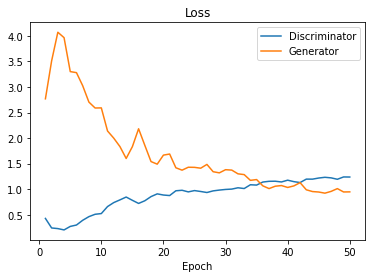

In [ ]:
def plot_history(history):
    fig, ax = plt.subplots()

    # 損失の推移を描画する。
    ax.set_title("Loss")
    ax.plot(history["epoch"], history["D_loss"], label="Discriminator")
    ax.plot(history["epoch"], history["G_loss"], label="Generator")
    ax.set_xlabel("Epoch")
    ax.legend()

    plt.show()


plot_history(history)

- 上述の通り，学習初期（～5epoch）はDが優位に進んでいたが，徐々にGの学習が進み$L_G$が減少している．
- GANの理想状態はDiscriminatorがxとG(z)の区別ができない状態＝0か1かをランダムに予測するしかない状態である．

### 生成画像の可視化
- 続いて，固定で利用しているfixed_zを用いた画像生成のエポックごとの変化を可視化する．

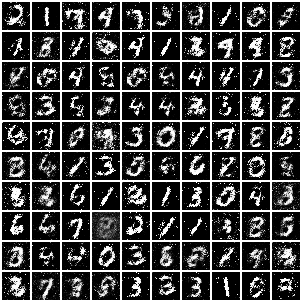

In [ ]:
def create_animation(imgs):
    imgs[0].save(
        "history-.gif", save_all=True, append_images=imgs[1:], duration=500, loop=0
    )

# 各エポックの画像で gif アニメーションを作成する。
create_animation(history["img"])
# 最終エポックの画像を表示する．
history['img'].iloc[-1]